In [2]:
from cmdstanpy import CmdStanModel
import arviz as az
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
_BASE_URL = "https://raw.githubusercontent.com/KAIR-ISZ/lectures/main/Data%20Analytics/Lab%205/Airline_data.csv"
df = pd.read_csv(_BASE_URL)
display(df)
print(df.describe())

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
0,1976,24,734,3863.0
1,1977,25,516,4300.0
2,1978,31,754,5027.0
3,1979,31,877,5481.0
4,1980,22,814,5814.0
5,1981,21,362,6033.0
6,1982,26,764,5877.0
7,1983,20,809,6223.0
8,1984,16,223,7433.0
9,1985,22,1066,7107.0


             Year  Fatal accidents  Passenger deaths  \
count    10.00000        10.000000         10.000000   
mean   1980.50000        23.800000        691.900000   
std       3.02765         4.709329        252.389228   
min    1976.00000        16.000000        223.000000   
25%    1978.25000        21.250000        570.500000   
50%    1980.50000        23.000000        759.000000   
75%    1982.75000        25.750000        812.750000   
max    1985.00000        31.000000       1066.000000   

       Miles flown [100 mln miles]  
count                    10.000000  
mean                   5715.800000  
std                    1117.767795  
min                    3863.000000  
25%                    5140.500000  
50%                    5845.500000  
75%                    6175.500000  
max                    7433.000000  


Perform prior predictive analysis to choose priors.

In [3]:
model_ppc=CmdStanModel(stan_file='lab5/lab5_ppc.stan')
sim = model_ppc.sample(data=dict(N=len(df), milesFlown=df["Miles flown [100 mln miles]"].values))

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed

INFO:cmdstanpy:CmdStan done processing.


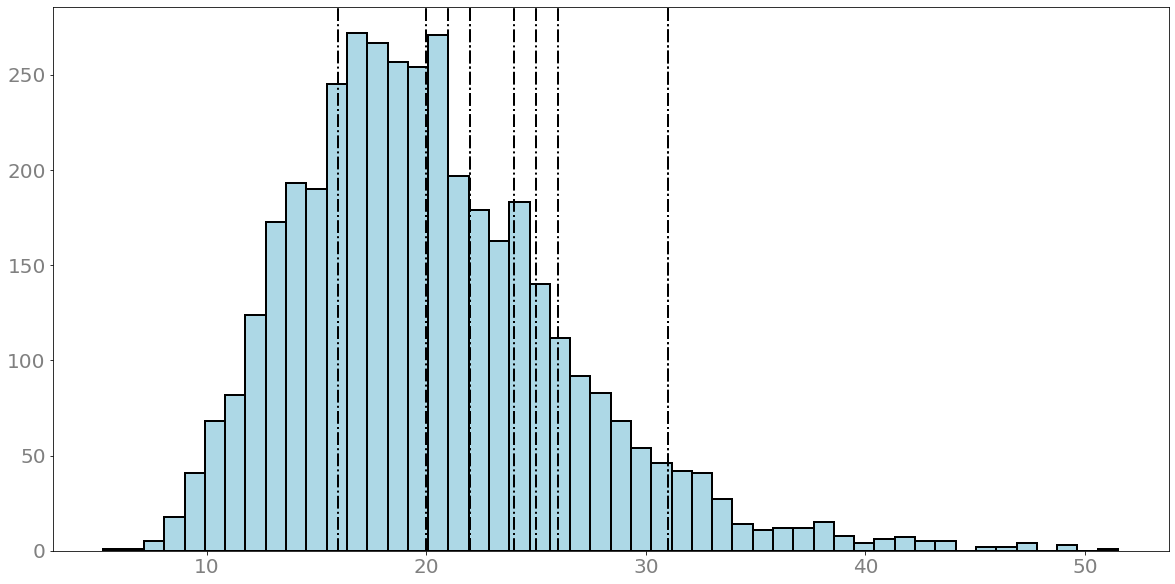

In [4]:
sim_pd = sim.draws_pd()
fig = plt.figure(figsize=(20, 10))

sim_pd["y_mean"] = sim_pd[[f"y[{i}]" for i in range(1, 11)]].mean(axis=1)
sim_pd["y_mean"].hist(bins=50, color="lightblue", edgecolor="black", linewidth=2)
for value in df["Fatal accidents"]:
    plt.axvline(value, color="black", linewidth=2, linestyle="-.")
plt.grid()
plt.xticks(fontsize=20, color='grey')
plt.yticks(fontsize=20, color='grey')
plt.show()

Fit the model to data and evaluate its efficiency by by posterior predictive distribution and comparing histograms of accidents for entire period and for each year.

In [10]:
model_fit=CmdStanModel(stan_file='lab5/lab5_fit.stan')
fit = model_fit.sample(data=dict(N=len(df), 
                                milesFlown=df["Miles flown [100 mln miles]"].values, 
                                accidents=df["Fatal accidents"].values),
                                chains=1)


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


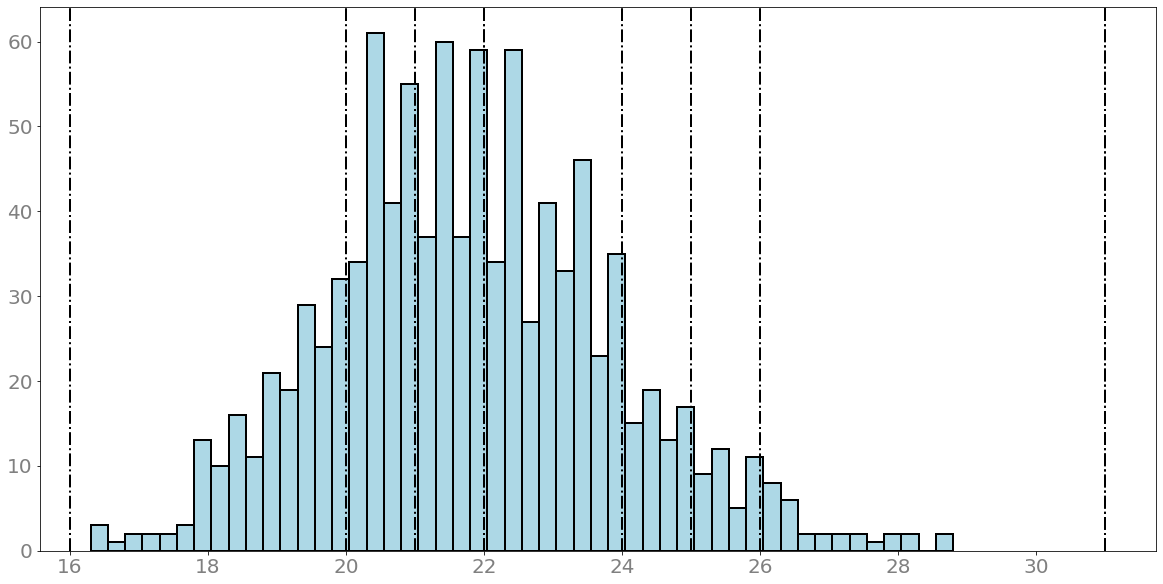

In [11]:
fit_pd = fit.draws_pd()
fig = plt.figure(figsize=(20, 10))
fit_pd["y_mean"] = fit_pd[[f"y[{i}]" for i in range(1, 11)]].mean(axis=1)
fit_pd["y_mean"].hist(bins=50, color="lightblue", edgecolor="black", linewidth=2)
for value in df["Fatal accidents"]:
    plt.axvline(value, color="black", linewidth=2, linestyle="-.")
plt.grid()
plt.xticks(fontsize=20, color='grey')
plt.yticks(fontsize=20, color='grey')
plt.show()

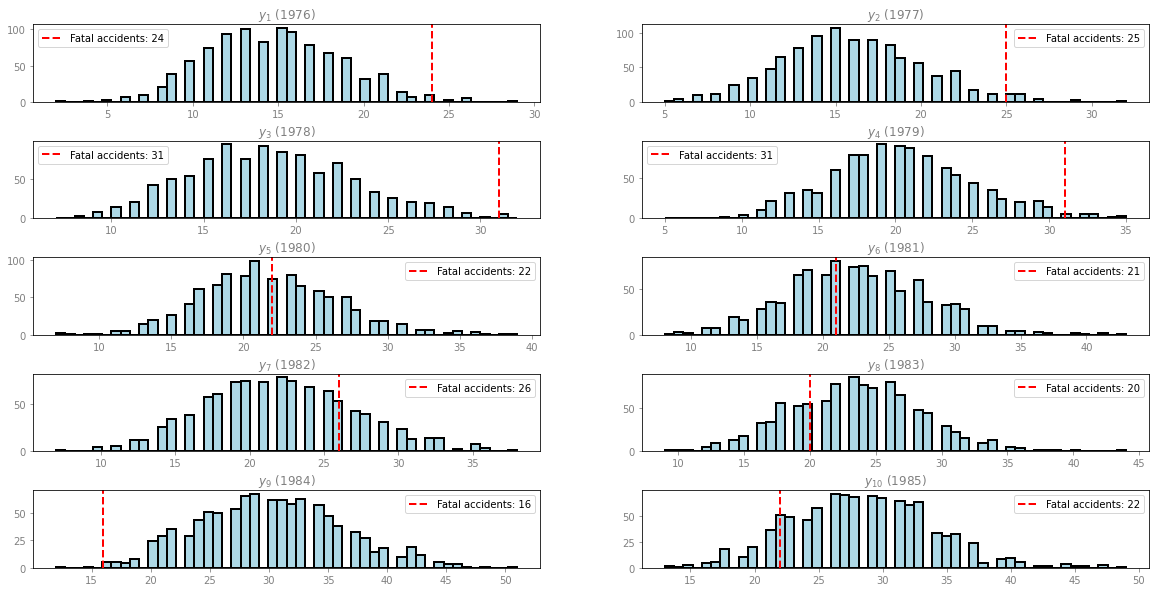

In [12]:
fit_pd = fit.draws_pd()
fig, axs = plt.subplots(5, 2, figsize=(20, 10))
fig.subplots_adjust(hspace=0.5)
for i, ax in enumerate(axs.flat):
    ax.hist(fit_pd[f"y[{i+1}]"], bins=50, color="lightblue", edgecolor="black", linewidth=2)
    ax.axvline(df["Fatal accidents"][i], color="red", linewidth=2, linestyle='--', label=f"Fatal accidents: {df['Fatal accidents'][i]}")
    ax.set_title(f"$y_{{{i+1}}}$ ({1976 + i})", fontsize=12, color="grey")
    ax.tick_params(axis='both', colors='grey')
    ax.legend()
plt.show()

Improve the model by replacing single intercept alpha with individual intercepts of alpha_i for each year. It can be easily done, by declaring alpha as an array of appropriate dimension. Then only one prior is needed as it will be used for all the elements of the array.

In [16]:
model_ppc2=CmdStanModel(stan_file='lab5/lab5_ppc2.stan')
sim2 = model_ppc2.sample(data=dict(N=len(df), milesFlown=df["Miles flown [100 mln miles]"].values))

INFO:cmdstanpy:compiling stan file /lab5/lab5_ppc2.stan to exe file /lab5/lab5_ppc2
INFO:cmdstanpy:compiled model executable: /lab5/lab5_ppc2
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration: 300 / 1000 [ 30%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed

INFO:cmdstanpy:CmdStan done processing.


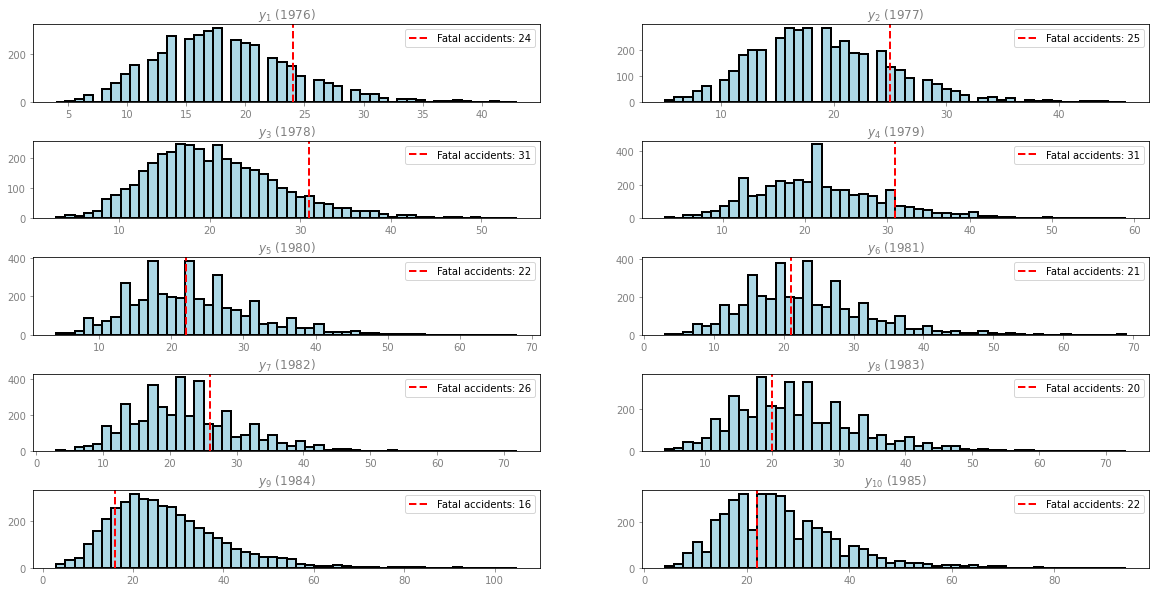

In [17]:
sim2_pd = sim2.draws_pd()
fig, axs = plt.subplots(5, 2, figsize=(20, 10))
fig.subplots_adjust(hspace=0.5)
for i, ax in enumerate(axs.flat):
    ax.hist(sim2_pd[f"y[{i+1}]"], bins=50, color="lightblue", edgecolor="black", linewidth=2)
    ax.axvline(df["Fatal accidents"][i], color="red", linewidth=2, linestyle='--', label=f"Fatal accidents: {df['Fatal accidents'][i]}")
    ax.set_title(f"$y_{{{i+1}}}$ ({1976 + i})", fontsize=12, color="grey")
    ax.tick_params(axis='both', colors='grey')
    ax.legend()
plt.show()

In [20]:
model_fit2=CmdStanModel(stan_file='lab5/lab5_fit2.stan')
fit2 = model_ppc2.sample(data=dict(N=len(df), milesFlown=df["Miles flown [100 mln miles]"].values))

INFO:cmdstanpy:compiling stan file /lab5/lab5_fit2.stan to exe file /lab5/lab5_fit2
INFO:cmdstanpy:compiled model executable: /lab5/lab5_fit2
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                      


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


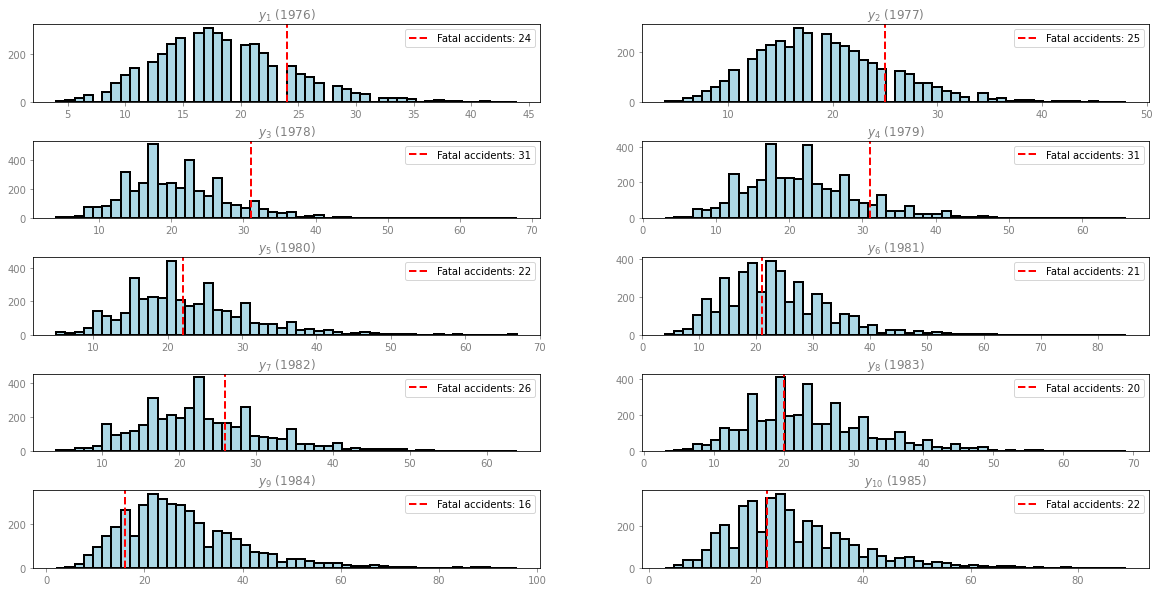

In [21]:
fit2_pd = fit2.draws_pd()
fig, axs = plt.subplots(5, 2, figsize=(20, 10))
fig.subplots_adjust(hspace=0.5)
for i, ax in enumerate(axs.flat):
    ax.hist(fit2_pd[f"y[{i+1}]"], bins=50, color="lightblue", edgecolor="black", linewidth=2)
    ax.axvline(df["Fatal accidents"][i], color="red", linewidth=2, linestyle='--', label=f"Fatal accidents: {df['Fatal accidents'][i]}")
    ax.set_title(f"$y_{{{i+1}}}$ ({1976 + i})", fontsize=12, color="grey")
    ax.tick_params(axis='both', colors='grey')
    ax.legend()
plt.show()